In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from functions import *
import torch
from torch.utils.data import Dataset
import h5py
from torch import nn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from Python.src.DataProcessing import Propagator_Dataset

In [4]:
# Para comparar una trayectoria completa

# Carga el modelo
model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth',map_location=torch.device('cpu'))

# Carga los datos nuevos
data_directory = './DataNew/ngrid32_delta_20250116-193307.h5'
dataset = Propagator_Dataset(path=data_directory, data='dataset_X', targets='dataset_y')
test_loader = DataLoader(dataset)

In [5]:
# Función que calcula el MAE de una base de datos

def MAE_wp(dataloader, model, device):
    MAE = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        pred = model(X.float()).squeeze()
        MAE.append(np.mean(np.abs((pred - y.float()).detach().numpy()), axis=1))
    return MAE, batch

In [33]:
for X,y in test_loader:
    print(y[:,1:5,:].shape)
    break

torch.Size([1, 4, 64])


In [30]:
def model_traj(data, model, device, fs):
    X, y = data
    prediction = np.zeros([fs, len(y[0,0])])
    #pred = model(X[:,0:1,:].to(device).float())
    #prediction[0] = X[:,0:1,0:256].detach().numpy()[0,0]
    X_new = X
    for i in range(fs):
        with torch.inference_mode():
            pred = model(X_new[:,i:i+1,:].to(device).float())
        prediction[i] = pred.detach().numpy()[0,0]
        X_new[:,i+1:i+2,0:256]=pred
        #print(i)
    return prediction


In [35]:
for X,y in test_loader:
    model_traj((X,y), model, device,10)
    break

RuntimeError: The expanded size of the tensor (96) must match the existing size (64) at non-singleton dimension 2.  Target sizes: [1, 1, 96].  Tensor sizes: [64]

In [31]:
# Calcula la trayectoria de una onda inicial

def model_traj1(data, model, device, fs, fs_story, fs_print:int = 0):
    X, y = data
    prediction = np.zeros([fs, len(y[0,0])])
    pred = model(X[:,0:1,:].to(device).float())
    prediction[0] = pred.detach().numpy()[0,0]
    X_new = X
    X_new[:,1:2,0:256]=pred
    for i in range(1, fs-1):
        if i<fs_story:
            with torch.inference_mode():
                pred = model(X_new[:,0:i+1,:].to(device).float())[:,i:i+1,:]
        else:
            with torch.inference_mode():
                pred = model(X_new[:,i - fs_story:i+1,:].to(device).float())[:,fs_story:fs_story+1,:]
        prediction[i] = pred.detach().numpy()[0,0]
        X_new[:,i:i+1,0:256]=pred
        if (i+1)%fs_print==0:
            print(f"Voy en el pasito {i+1} fs")
        #print(i)
    return prediction


In [32]:
#model = torch.load('/Users/romanarmenta/Documents/Proyectos/LSTM_Propagator_Jessica/200fs_1000epochs_6300trainsamples_better_model.pth',map_location=torch.device('cpu'))
device = torch.device("cpu")
fs_lens = [1]
fs_pred = 1_000
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Input = X
    
    Output = y[:,0:fs_pred,:]
    predictions = np.zeros([len(fs_lens), fs_pred, len(y[0,0])])
    thinguisis = np.zeros([len(fs_lens), fs_pred])
    for i in range(len(fs_lens)):
        fss = fs_lens[i]
        with torch.inference_mode():
            #Prediction = torch.tensor(model_traj((X,y), model, device, fs_pred))[None, :, :]
            Prediction = torch.tensor(model_traj1((X,y), model, device, fs_pred, 1, 100))[None, :, :]
            predictions[i,:,:] = Prediction.detach().numpy()
            thinguis = torch.mean(torch.pow(Prediction - Output,2), dim=2)
            thinguisis[i,:] = thinguis.detach().numpy()
    break

RuntimeError: The expanded size of the tensor (96) must match the existing size (64) at non-singleton dimension 2.  Target sizes: [1, 1, 96].  Tensor sizes: [64]

1


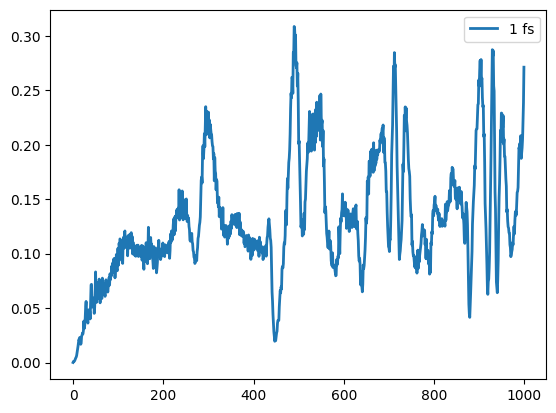

In [88]:
for i in range(len(fs_lens)):
    plt.plot(thinguisis[i], label=f"{fs_lens[i]} fs")
    print(fs_lens[i])
    plt.legend()

In [97]:
fs_training = [200, 300, 400]
fs_pred = 1_000
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Input = X
    
    Output = y[:,0:fs_pred,:]
    predictions = np.zeros([len(fs_training), fs_pred, len(y[0,0])])
    thinguisis = np.zeros([len(fs_training), fs_pred])
    for i in range(len(fs_training)):
        fs_train = fs_training[i]
        model = torch.load(f'/Users/romanarmenta/Documents/{fs_train}fs_1000epochs_6300trainsamples.pth',map_location=torch.device('cpu'))
        with torch.inference_mode():
            #Prediction = torch.tensor(model_traj((X,y), model, device, fs_pred))[None, :, :]
            Prediction = torch.tensor(model_traj1((X,y), model, device, fs_pred, 1, 100))[None, :, :]
            predictions[i,:,:] = Prediction.detach().numpy()
            thinguis = torch.mean(torch.pow(Prediction - Output,2), dim=2)
            thinguisis[i,:] = thinguis.detach().numpy()
    break

Voy en el pasito 100 fs
Voy en el pasito 200 fs
Voy en el pasito 300 fs
Voy en el pasito 400 fs
Voy en el pasito 500 fs
Voy en el pasito 600 fs
Voy en el pasito 700 fs
Voy en el pasito 800 fs
Voy en el pasito 900 fs
Voy en el pasito 100 fs
Voy en el pasito 200 fs
Voy en el pasito 300 fs
Voy en el pasito 400 fs
Voy en el pasito 500 fs
Voy en el pasito 600 fs
Voy en el pasito 700 fs
Voy en el pasito 800 fs
Voy en el pasito 900 fs
Voy en el pasito 100 fs
Voy en el pasito 200 fs
Voy en el pasito 300 fs
Voy en el pasito 400 fs
Voy en el pasito 500 fs
Voy en el pasito 600 fs
Voy en el pasito 700 fs
Voy en el pasito 800 fs
Voy en el pasito 900 fs


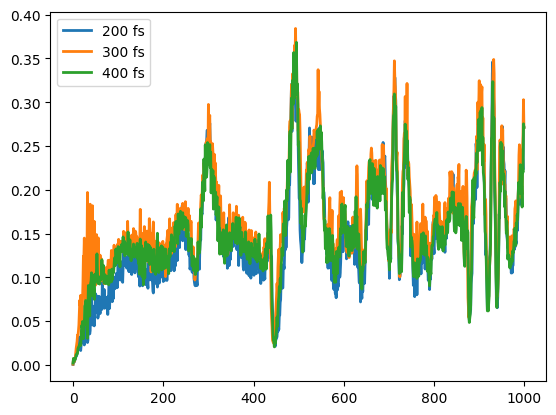

In [98]:
for i in range(len(fs_training)):
    plt.plot(thinguisis[i], label=f"{fs_training[i]} fs")
    plt.legend()

In [99]:
Prediction = torch.tensor(predictions[2:3,:,:])

print(Input.shape)
print(Prediction.shape)
print(Output.shape)

torch.Size([1, 1000, 384])
torch.Size([1, 1000, 256])
torch.Size([1, 1000, 256])


In [100]:
# General parameters
n_grid = 128  # number of points on the grid
seq_len = 1000  # number of steps in trajectories
a = -1.5  # initial point in angstroms
b = 1.5  # final point in angstroms
dat = 0

r_n = torch.linspace(a,b,n_grid)

color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

In [101]:
def wavefunction(part, time, source):
    
    if source == 'input':
        if part == 'real':
            in_real_t = Input[dat,time,0:n_grid].detach().numpy()
            return in_real_t
        
        if part == 'complex':
            in_imag_t = Input[dat,time,n_grid:n_grid*2].detach().numpy()
            return in_imag_t
        
        
    if source == 'output':
        if part == 'real':
            ou_real_t = Output[dat,time,0:n_grid].detach().numpy()
            return ou_real_t
        
        if part == 'complex':
            ou_imag_t = Output[dat,time,n_grid:n_grid*2].detach().numpy()
            return ou_imag_t
        
    if source == 'prediction':
        if part == 'real':
            pred_real_t = Prediction[dat,time,0:n_grid].detach().numpy()
            return pred_real_t
        
        if part == 'complex':
            pred_imag_t = Prediction[dat,time,n_grid:n_grid*2].detach().numpy()
            return pred_imag_t

In [102]:
def potential(time):
    pot = Input[dat,time,n_grid*2:n_grid*3].detach().numpy()
    return pot

def density(time, source):
    
    if time == 0:
        dens = (np.abs(np.vectorize(complex)(wavefunction('real',time,'input'),wavefunction('complex', time, 'input'))))**2
        return dens
    
    if source == 'output':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t
    
    if source == 'prediction':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t

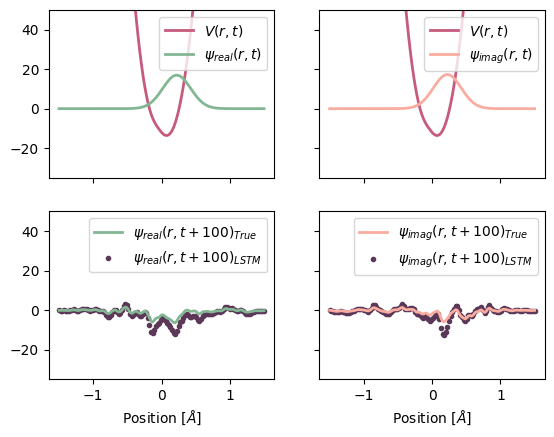

In [103]:
#plt.rcParams['figure.figsize'] = [40, 20]

fig, axs = plt.subplots(2,2)
time = int(0)
time2 = int(1)
r_n = np.linspace(a,b,n_grid)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, potential(time)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, wavefunction('real', time, 'input')*20, label=r"$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, potential(time)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, wavefunction('complex', time, 'input')*20, label=r"$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, (wavefunction('real', time2, 'output')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, (wavefunction('real', time2, 'prediction')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, (wavefunction('complex', time2, 'output')+wavefunction('complex', time2, 'input'))*20, label=r"$\psi_{imag}(r, t+100)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, (wavefunction('complex', time2, 'prediction')+wavefunction('complex', time2, 'input'))*20, label=r"$\psi_{imag}(r, t+100)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel=r'Position [$\AA$]')
    ax.label_outer()
    pass
 
#plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()

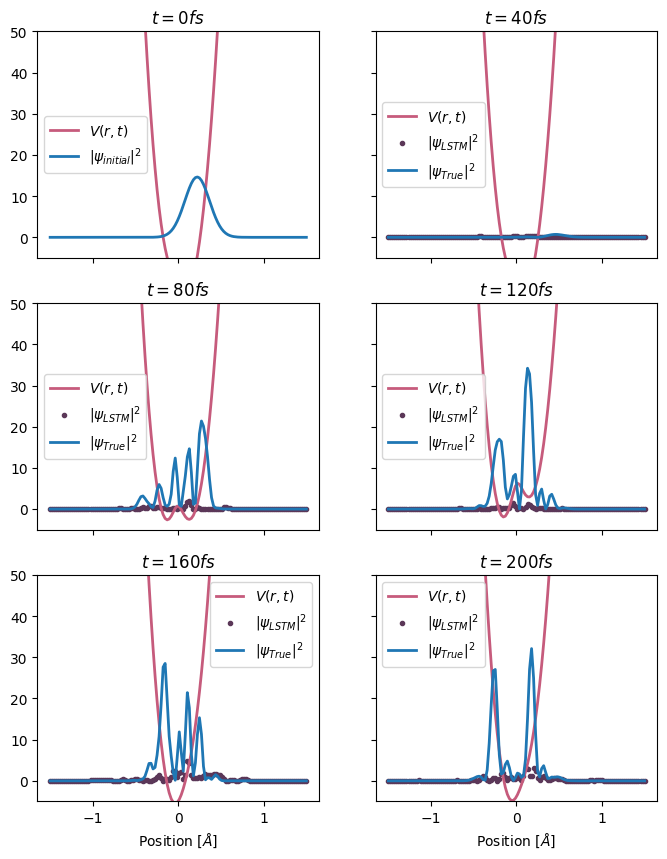

In [104]:
fig, ax = plt.subplots(3,2)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol

# t = 0
ax[0,0].plot(r_n, potential(0)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])
ax[0,0].plot(r_n, density(0, 'output')*10, label=r"$|\psi_{initial}|^{2}$")
ax[0,0].set_title(r"$t=0 fs$")

# t = 1
ax[0,1].plot(r_n, potential(1)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])
ax[0,1].scatter(r_n, density(4, 'prediction')*10, label=r"$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[0,1].plot(r_n, density(4, 'output')*10, label=r"$|\psi_{True}|^{2}$")
ax[0,1].set_title(r"$t=40 fs$")

# t = 80
ax[1,0].plot(r_n, potential(80)*(1/1.5936e-3), "-", label=r"$V(r, t)$", color=color[3])
ax[1,0].scatter(r_n, density(80, 'prediction')*10, label=r"$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,0].plot(r_n, density(80, 'output')*10, label=r"$|\psi_{True}|^{2}$")
ax[1,0].set_title(r"$t=80 fs$")

# t = 120
ax[1,1].plot(r_n, potential(120)*(1/1.5936e-3), "-", label=r"$V(r, t)$", color=color[3])
ax[1,1].scatter(r_n, density(120,'prediction')*(10), label=r"$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,1].plot(r_n, density(120,'output')*10, label=r"$|\psi_{True}|^{2}$")
ax[1,1].set_title(r"$t=120 fs$")

# t = 160
ax[2,0].plot(r_n, potential(160)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])
ax[2,0].scatter(r_n, density(160,'prediction')*(10), label=r"$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,0].plot(r_n, density(160, 'output')*10, label=r"$|\psi_{True}|^{2}$")
ax[2,0].set_title(r"$t=160 fs$")

# t = 200
ax[2,1].plot(r_n, potential(199)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])
ax[2,1].scatter(r_n, density(199, 'prediction')*(10), label=r"$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,1].plot(r_n, density(199, 'output')*10, label=r"$|\psi_{True}|^{2}$")
ax[2,1].set_title(r"$t=200 fs$")

for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-5, 50])
        axr11.legend()
        axr11.set(xlabel=r'Position [$\AA$]')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(8, 10)
#plt.legend()    
plt.show()

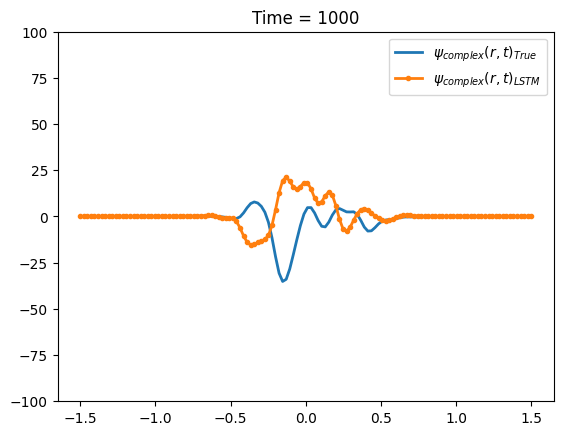

In [108]:
import matplotlib.animation as animation

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
#axs[1,0].plot(r_n, (wavefunction('real', time2, 'output')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{True}$", color=color[0])  # Escaled
#axs[1,0].scatter(r_n, (wavefunction('real', time2, 'prediction')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{LSTM}$", color=color[4], marker='.')  # Escaled

plt.rcParams['lines.linewidth'] = 2

fig, axes = plt.subplots()
prob = axes.plot(r_n, (wavefunction('complex', 0, 'output')+wavefunction('complex', 0, 'input'))*20, label=r"$\psi_{complex}(r, t)_{True}$")[0]
target = axes.plot(r_n, (wavefunction('complex', 0, 'prediction')+wavefunction('complex', 0, 'input'))*20, label=r"$\psi_{complex}(r, t)_{LSTM}$", marker='.')[0]  # Escaled

axes.set_ylim([-100., 100.])
#axes.grid()
axes.set_title(f'Distribución: epoch = {1}')

#trans = axes[1].plot(x,z_list[0].detach().numpy())
#axes[1].set_title('x -> z')

axes.legend()
#plt.show()

def update(frame):
    # for each frame, update the data stored on each artist.
    px = (wavefunction('complex', frame, 'output')+wavefunction('complex', frame, 'input'))*20
    z = (wavefunction('complex', frame, 'prediction')+wavefunction('complex', frame, 'input'))*20
    # update the scatter plot:
    #data_dist = np.stack([x, px]).T
    #prob.set_xdata(x)
    prob.set_ydata(px)
    axes.set_title(f"Time = {frame+1}")
    #prob.set_offsets(data_dist)
    target.set_ydata(z)

    #data_trans = np.stack([x, z]).T
    #trans.set_offsets(data_trans)
    #trans.set_xdata(x)
    #trans.set_ydata(z)

    # update the line plot:
    #line2.set_xdata(t[:frame])
    #line2.set_ydata(z2[:frame])
    return prob, target


ani = animation.FuncAnimation(fig=fig, func=update, frames=1_000, interval=100)
ani.save(filename="./illow_example_complex_2.gif", writer="pillow")
plt.show()

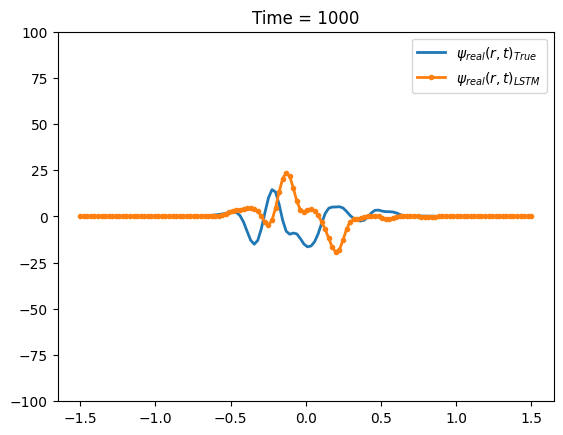

In [106]:
import matplotlib.animation as animation

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
#axs[1,0].plot(r_n, (wavefunction('real', time2, 'output')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{True}$", color=color[0])  # Escaled
#axs[1,0].scatter(r_n, (wavefunction('real', time2, 'prediction')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{LSTM}$", color=color[4], marker='.')  # Escaled

plt.rcParams['lines.linewidth'] = 2

fig, axes = plt.subplots()
prob = axes.plot(r_n, (wavefunction('real', 0, 'output')+wavefunction('real', 0, 'input'))*20, label=r"$\psi_{real}(r, t)_{True}$")[0]
target = axes.plot(r_n, (wavefunction('real', 0, 'prediction')+wavefunction('real', 0, 'input'))*20, label=r"$\psi_{real}(r, t)_{LSTM}$", marker='.')[0]  # Escaled

axes.set_ylim([-100., 100.])
#axes.grid()
axes.set_title(f'Distribución: epoch = {1}')

#trans = axes[1].plot(x,z_list[0].detach().numpy())
#axes[1].set_title('x -> z')

axes.legend()
#plt.show()

def update(frame):
    # for each frame, update the data stored on each artist.
    px = (wavefunction('real', frame, 'output')+wavefunction('real', frame, 'input'))*20
    z = (wavefunction('real', frame, 'prediction')+wavefunction('real', frame, 'input'))*20
    # update the scatter plot:
    #data_dist = np.stack([x, px]).T
    #prob.set_xdata(x)
    prob.set_ydata(px)
    axes.set_title(f"Time = {frame+1}")
    #prob.set_offsets(data_dist)
    target.set_ydata(z)

    #data_trans = np.stack([x, z]).T
    #trans.set_offsets(data_trans)
    #trans.set_xdata(x)
    #trans.set_ydata(z)

    # update the line plot:
    #line2.set_xdata(t[:frame])
    #line2.set_ydata(z2[:frame])
    return prob, target


ani = animation.FuncAnimation(fig=fig, func=update, frames=1_000, interval=100)
ani.save(filename="./illow_example_real_2.gif", writer="pillow")
plt.show()

/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_28177/3748937829.py:38: RuntimeWarning: invalid value encountered in divide
  target.set_ydata(z/np.sum(z))


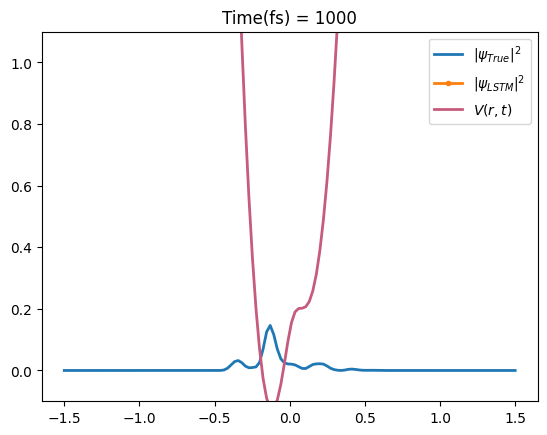

In [107]:
import matplotlib.animation as animation
from scipy.stats import norm                                                  

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
#axs[1,0].plot(r_n, (wavefunction('real', time2, 'output')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{True}$", color=color[0])  # Escaled
#axs[1,0].scatter(r_n, (wavefunction('real', time2, 'prediction')+wavefunction('real', time2, 'input'))*20, label=r"$\psi_{real}(r, t+100)_{LSTM}$", color=color[4], marker='.')  # Escaled

plt.rcParams['lines.linewidth'] = 2

fig, axes = plt.subplots()
prob = axes.plot(r_n, density(0, 'output')*10, label=r"$|\psi_{True}|^{2}$")[0]
target = axes.plot(r_n, density(0, 'prediction')*10, label=r"$|\psi_{LSTM}|^{2}$", marker='.')[0]  # Escaled
pot = axes.plot(r_n, potential(0)*(1/1.5936e-3), "-", label=r"$V(r,t)$", color=color[3])[0]

axes.set_ylim([-0.1, 1.1])
#axes.grid()
axes.set_title(f'Distribución: epoch = {1}')

#trans = axes[1].plot(x,z_list[0].detach().numpy())
#axes[1].set_title('x -> z')

axes.legend()
#plt.show()

def update(frame):
    # for each frame, update the data stored on each artist.
    px = density(frame, 'output')*10
    z = density(frame, 'prediction')*10
    pote = potential(frame)*(1/1.5936e-3)

    # update the scatter plot:
    #data_dist = np.stack([x, px]).T
    #prob.set_xdata(x)
    prob.set_ydata(px/np.sum(px))
    axes.set_title(f"Time(fs) = {frame+1}")
    pot.set_ydata(pote/20)
    #prob.set_offsets(data_dist)
    target.set_ydata(z/np.sum(z))

    #data_trans = np.stack([x, z]).T
    #trans.set_offsets(data_trans)
    #trans.set_xdata(x)
    #trans.set_ydata(z)

    # update the line plot:
    #line2.set_xdata(t[:frame])
    #line2.set_ydata(z2[:frame])
    return prob, target, pot


ani = animation.FuncAnimation(fig=fig, func=update, frames=1_000, interval=150)
ani.save(filename="./illow_example_density_2.gif", writer="pillow")
plt.show()